In [1]:
import h5py
import numpy as np
import os
import cv2
from pathlib import Path

# Example paths (adjust as needed)
# angiographyDataFile = "/path/to/your/angiography.h5"
# nnUNetRawFolder = "/path/to/nnUNet/raw/folder"
angiographyDataFile = "/home/ubuntu/Angiostore/WebknossosAngiogramsRevisedUInt8List.h5"
annotationDataFile = "/home/ubuntu/Angiostore/WebknossosAnnotationsRevisedUnitized-5-Bitfield.h5"
annotationIndicizedDataFile = "/home/ubuntu/Angiostore/WebknossosAnnotationsRevisedIndicized-3.h5"
nnUNetRawFolder = "/home/ubuntu/Angiostore/nnUnet_raw"

In [2]:
def get_common_keys(angiographyDataFile, annotationDataFile):
    """
    Get the intersection of keys between the two HDF5 files
    """
    with h5py.File(angiographyDataFile, 'r') as f_angio, \
         h5py.File(annotationDataFile, 'r') as f_anno:
        
        angio_keys = set(f_angio.keys())
        anno_keys = set(f_anno.keys())
        common_keys = sorted(list(angio_keys.intersection(anno_keys)))
        
        print(f"Angiography keys: {len(angio_keys)}")
        print(f"Annotation keys: {len(anno_keys)}")
        print(f"Common keys: {len(common_keys)}")
        
        return common_keys


In [3]:
# Get common keys first
common_keys = get_common_keys(angiographyDataFile, annotationDataFile)

# If you want to see the keys before proceeding
print("Common keys:", common_keys)

Angiography keys: 172
Annotation keys: 146
Common keys: 145
Common keys: ['01_Case_CSF8U1R1_14', '01_Case_CSF8U1RQ_13', '03_Case_CSF8UKA1_2', '03_Case_CSF8UKA5_4', '03_Case_CSF8UKA9_1', '03_Case_CSF8UKAH_5', '06_Case_CSF8W343_9', '06_Case_CSF8W34C_7', '07_Case_CSF8W6GE_7', '07_Case_CSF8W6GK_4', '07_Case_CSF8W6GS_8', '07_Case_CSF8W6GY_6', '10_Case_CSF8WNXU_5', '10_Case_CSF8WNY6_1', '11_Case_CSF8X226_2', '12_Case_CSF8XAD2_23', '12_Case_CSF8XADW_10', '13_Case_CSVS1XAP_1', '13_Case_CSVS1XAU_6', '13_Case_CSVS1XB4_2', '13_Case_CSVS1XBI_4', '14_Case_CSVS23F6_14', '14_Case_CSVS23FO_5', '14_Case_CSVS23FS_4', '15_Case_CSVS35IV_3', '20_Case_CSVS6EJE_1', '20_Case_CSVS6EJZ_5', '20_Case_CSVS6EKN_3', 'Angios_005_rev', 'Angios_006_rev', 'Angios_007_rev', 'Angios_013_rev', 'Angios_015_rev', 'Angios_016_rev', 'Angios_021_rev', 'Angios_022_rev', 'Angios_030_rev', 'Angios_031_rev', 'Angios_032_rev', 'Angios_033_rev', 'Angios_048_rev', 'Angios_061_rev', 'Angios_063_rev', 'Angios_065_rev', 'Angios_067_rev',

In [4]:

def export_angiography_to_nnunet(angiographyDataFile, nnUNetRawFolder, common_keys):
    """
    Modified to only process common keys
    """
    images_dir = os.path.join(nnUNetRawFolder, 'imagesTr')
    Path(images_dir).mkdir(parents=True, exist_ok=True)
    
    frameKeys=[]
    
    with h5py.File(angiographyDataFile, 'r') as f:
        blockCounter = 0
        
        # Only iterate through common keys
        for dataset_name in common_keys:
            print(f"Processing angiogram dataset: {dataset_name}")
            angio_data = f[dataset_name][:]
            
            n_frames = angio_data.shape[0]
            
            for center_idx in range(2, n_frames - 2):
                frameKeys.append([dataset_name, center_idx])
                frame_indices = range(center_idx - 2, center_idx + 3)
                frames = angio_data[frame_indices]
                
                for frame_num, frame in enumerate(frames):
                    if frame.dtype != np.uint8:
                        if frame.max() > 1:
                            frame = (frame / frame.max() * 255).astype(np.uint8)
                        else:
                            frame = (frame * 255).astype(np.uint8)
                    
                    filename = f'Angios_{blockCounter:04d}_{frame_num:04d}.png'
                    filepath = os.path.join(images_dir, filename)
                    cv2.imwrite(filepath, frame)
                
                blockCounter += 1
        
        print(f"Exported {blockCounter} sets of 5 frames each")
        print(f"Total number of PNG files created: {blockCounter * 5}")
        return frameKeys


In [5]:
frameKeys = export_angiography_to_nnunet(angiographyDataFile, nnUNetRawFolder, common_keys)


Processing angiogram dataset: 01_Case_CSF8U1R1_14
Processing angiogram dataset: 01_Case_CSF8U1RQ_13
Processing angiogram dataset: 03_Case_CSF8UKA1_2
Processing angiogram dataset: 03_Case_CSF8UKA5_4
Processing angiogram dataset: 03_Case_CSF8UKA9_1
Processing angiogram dataset: 03_Case_CSF8UKAH_5
Processing angiogram dataset: 06_Case_CSF8W343_9
Processing angiogram dataset: 06_Case_CSF8W34C_7
Processing angiogram dataset: 07_Case_CSF8W6GE_7
Processing angiogram dataset: 07_Case_CSF8W6GK_4
Processing angiogram dataset: 07_Case_CSF8W6GS_8
Processing angiogram dataset: 07_Case_CSF8W6GY_6
Processing angiogram dataset: 10_Case_CSF8WNXU_5
Processing angiogram dataset: 10_Case_CSF8WNY6_1
Processing angiogram dataset: 11_Case_CSF8X226_2
Processing angiogram dataset: 12_Case_CSF8XAD2_23
Processing angiogram dataset: 12_Case_CSF8XADW_10
Processing angiogram dataset: 13_Case_CSVS1XAP_1
Processing angiogram dataset: 13_Case_CSVS1XAU_6
Processing angiogram dataset: 13_Case_CSVS1XB4_2
Processing angio

In [35]:
# ... existing code ...

def bitfield_to_channels(bitfield_array: np.ndarray) -> np.ndarray:
    """
    Transform a 3D array of uint8 bitfields into a 4D array of separate class channels.
    
    Args:
        bitfield_array: Input array of shape (frames, height, width) containing uint8 bitfields
        
    Returns:
        np.ndarray: Output array of shape (8, frames, height, width) where each channel
                   represents the presence of a specific class (bit position)
                   
    Example:
        >>> input_array = np.array([[[1, 2], [3, 4]]], dtype=np.uint8)
        >>> output = bitfield_to_channels(input_array)
        >>> # output[0] will be the mask for bit 0
        >>> # output[1] will be the mask for bit 1
        >>> # etc.
    """
    # Get the shape of the input array
    frames, height, width = bitfield_array.shape
    
    # Initialize output array with shape (8, frames, height, width)
    output = np.zeros((8, frames, height, width), dtype=np.uint8)
    
    # For each bit position (0-7)
    for bit in range(8):
        # Create a mask for this bit position
        mask = 1 << bit
        # Check if the bit is set in each position
        output[bit] = (bitfield_array & mask).astype(bool).astype(np.uint8)
    
    return output

# Example usage:
# channels = bitfield_to_channels(example_data)
# print(f"Input shape: {example_data.shape}")
# print(f"Output shape: {channels.shape}")
# print(f"Number of non-zero pixels per channel:")
# for i in range(8):
#     print(f"Channel {i}: {np.sum(channels[i])}")

In [53]:
def indicize_annotation(data):
        channels = bitfield_to_channels(data)
        catheter = channels[0]
        vessel =  (channels[1] - channels[1]*channels[2]) 
        result = catheter + 2 * vessel - catheter*vessel
        
        return result

In [54]:

def indicize_annotations(annotationDataFile, annotationIndicizedDataFile):
    """
    Transform 5-channel unitized annotations to single-channel indicized format.
    
    Rules:
    (0,0,0,*,*) -> 0  # background
    (0,1,0,*,*) -> 1  # catheter
    (0,0,1,0,*) -> 2  # vessel
    (0,0,*,1,*) -> 0  # stenosis (maps to background)
    """
    
    # Open both files
    with h5py.File(annotationDataFile, 'r') as f_in, \
         h5py.File(annotationIndicizedDataFile, 'w') as f_out:
        
        # Process each dataset
        for dataset_name in f_in.keys():
            print(f"Processing dataset: {dataset_name}")
            
            # Read input data
            data = f_in[dataset_name][:]
            print(f"Dataset shape: {data.shape}")
            # channels = bitfield_to_channels(data)
            # print(f"channels shape: {channels.shape}")
            indicized = indicize_annotation(data)
            print(f"Indicized shape: {indicized.shape}")
            
            # Create output dataset
            output_shape = indicized.shape
            dset_out = f_out.create_dataset(
                dataset_name,
                output_shape,
                dtype=np.uint8
            )
            
            # Write transformed data
            dset_out[:] = indicized
            
            # Verify unique values
            unique_values = np.unique(dset_out[:])
            print(f"  Dataset {dataset_name} unique values: {unique_values}")
            
        print("Transformation complete!")

# Example usage:
# transform_annotations(annotationDataFile, annotationIndicizedDataFile)

# For debugging, let's also print the shape of the first dataset
with h5py.File(annotationDataFile, 'r') as f:
    first_dataset_name = list(f.keys())[0]
    first_dataset = f[first_dataset_name][:]
    print(f"First dataset shape: {first_dataset.shape}")

First dataset shape: (39, 512, 512)


In [47]:
# Example paths (adjust as needed)
# annotationDataFile = "/path/to/5channel/annotations.h5"
# annotationIndicizedDataFile = "/path/to/output/indicized_annotations.h5"

indicize_annotations(annotationDataFile, annotationIndicizedDataFile)

Processing dataset: 01_Case_CSF8U1R1_14
Dataset shape: (39, 512, 512)
Indicized shape: (39, 512, 512)
  Dataset 01_Case_CSF8U1R1_14 unique values: [0 2]
Processing dataset: 01_Case_CSF8U1RQ_13
Dataset shape: (50, 512, 512)
Indicized shape: (50, 512, 512)
  Dataset 01_Case_CSF8U1RQ_13 unique values: [0 2]
Processing dataset: 03_Case_CSF8UKA1_2
Dataset shape: (44, 512, 512)
Indicized shape: (44, 512, 512)
  Dataset 03_Case_CSF8UKA1_2 unique values: [0 1 2]
Processing dataset: 03_Case_CSF8UKA5_4
Dataset shape: (62, 512, 512)
Indicized shape: (62, 512, 512)
  Dataset 03_Case_CSF8UKA5_4 unique values: [0 1 2]
Processing dataset: 03_Case_CSF8UKA9_1
Dataset shape: (46, 512, 512)
Indicized shape: (46, 512, 512)
  Dataset 03_Case_CSF8UKA9_1 unique values: [0 1 2]
Processing dataset: 03_Case_CSF8UKAH_5
Dataset shape: (70, 512, 512)
Indicized shape: (70, 512, 512)
  Dataset 03_Case_CSF8UKAH_5 unique values: [0 1 2]
Processing dataset: 06_Case_CSF8W343_9
Dataset shape: (53, 512, 512)
Indicized sha

In [9]:
def get_hdf5_keys(hdf5_file: str) -> list[str]:
    """
    Get list of dataset keys in an HDF5 file.

    Args:
        hdf5_file: Path to the HDF5 file

    Returns:
        list[str]: List of dataset keys in the file
    """
    with h5py.File(hdf5_file, 'r') as f:
        keys = list(f.keys())
        print(f"Keys in {hdf5_file}:")
        for key in keys:
            print(f"  {key}")
        return keys

# Get keys from annotationIndicizedDataFile
keys = get_hdf5_keys(annotationIndicizedDataFile)


Keys in /home/ubuntu/Angiostore/WebknossosAnnotationsRevisedIndicized-3.h5:
  01_Case_CSF8U1R1_14
  01_Case_CSF8U1RQ_13
  03_Case_CSF8UKA1_2
  03_Case_CSF8UKA5_4
  03_Case_CSF8UKA9_1
  03_Case_CSF8UKAH_5
  06_Case_CSF8W343_9
  10_Case_CSF8WNXU_5
  10_Case_CSF8WNY6_1
  12_Case_CSF8XAD2_23
  12_Case_CSF8XADW_10
  13_Case_CSVS1XAP_1
  13_Case_CSVS1XAU_6
  13_Case_CSVS1XB4_2
  14_Case_CSVS23F6_14
  14_Case_CSVS23FO_5
  14_Case_CSVS23FS_4
  Angios_005_rev
  Angios_006_rev
  Angios_007_rev
  Angios_013_rev
  Angios_015_rev
  Angios_016_rev
  Angios_021_rev
  Angios_022_rev
  Angios_030_rev
  Angios_031_rev
  Angios_032_rev
  Angios_048_rev
  Angios_061_rev
  Angios_063_rev
  Angios_065_rev
  Angios_067_rev
  Angios_072_rev
  Angios_075_rev
  Angios_079_rev
  Angios_081_rev
  Angios_082_rev
  Angios_104_rev
  Angios_114_rev
  Angios_120_rev
  Angios_128_rev
  Angios_129_rev
  Angios_133_rev
  Angios_148_rev
  Angios_157_rev
  Angios_161_rev
  Angios_164_rev
  Angios_168_rev
  Angios_170_rev
 

In [10]:
len(keys)

129

In [48]:
import random
def get_dataset_data(hdf5_file: str, key: str) -> np.ndarray:
    """
    Get data from a specific dataset in an HDF5 file.

    Args:
        hdf5_file: Path to the HDF5 file
        key: Key of the dataset to retrieve

    Returns:
        np.ndarray: Data from the specified dataset
    """
    with h5py.File(hdf5_file, 'r') as f:
        data = f[key][:]
        print(f"Shape of dataset {key}: {data.shape}")
        return data

# Get data for "Napari_9_rev" dataset
key = random.choice(keys)
example_data = get_dataset_data(annotationIndicizedDataFile, "01_Case_CSF8U1RQ_13")
print(key, example_data.shape)


Shape of dataset 01_Case_CSF8U1RQ_13: (50, 512, 512)
Napari_39_rev (50, 512, 512)


In [49]:
# Convert the example data to separate channels
channels = bitfield_to_channels(example_data)

# Print some statistics
print(f"Input shape: {example_data.shape}")
print(f"Output shape: {channels.shape}")
print(f"Number of non-zero pixels per channel:")
for i in range(8):
    print(f"Channel {i}: {np.sum(channels[i])}")

Input shape: (50, 512, 512)
Output shape: (8, 50, 512, 512)
Number of non-zero pixels per channel:
Channel 0: 0
Channel 1: 1104
Channel 2: 0
Channel 3: 0
Channel 4: 0
Channel 5: 0
Channel 6: 0
Channel 7: 0


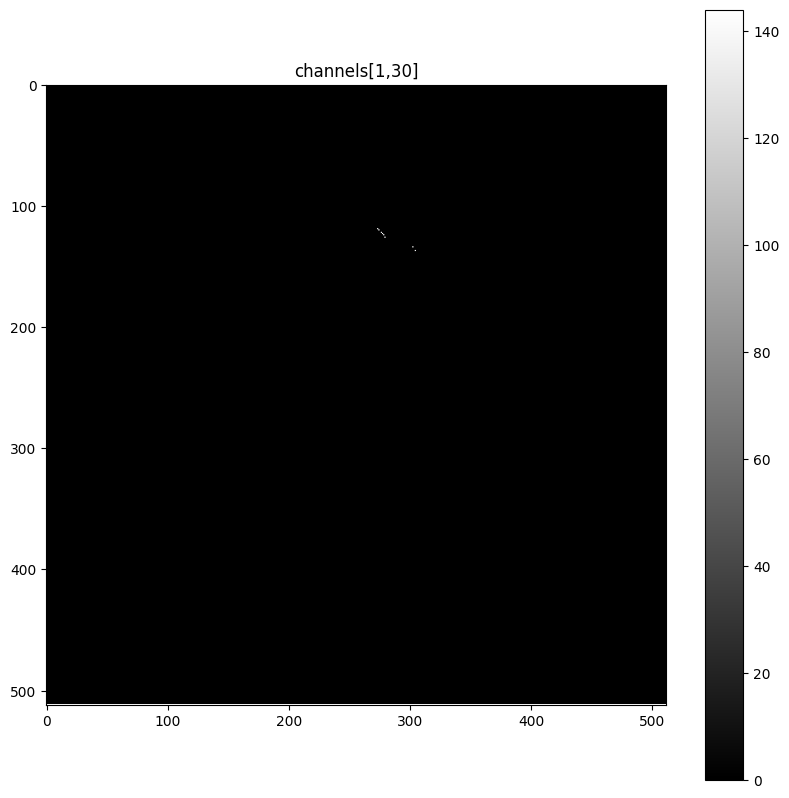

In [58]:
plt.figure(figsize=(10, 10))
plt.imshow(200*example_data[20], cmap='gray')
plt.colorbar()
plt.title('channels[1,30]')
plt.axis('on')
plt.show()


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

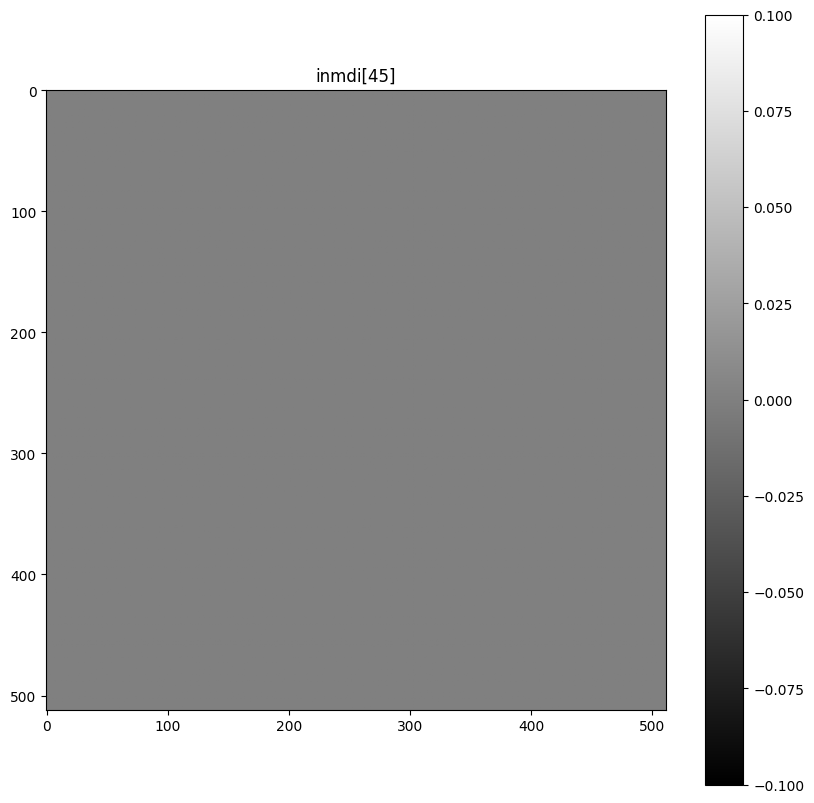

In [55]:
inmdi=indicize_annotation(example_data)
inmdi.shape
plt.figure(figsize=(10, 10))
plt.imshow(inmdi[45], cmap='gray')
plt.colorbar()
plt.title('inmdi[45]')
plt.axis('on')

In [59]:
# Tabulate unique values and their counts in inmdi
unique_values, counts = np.unique(example_data, return_counts=True)
print("Value\tCount")
print("-----\t-----")
for val, count in zip(unique_values, counts):
    print(f"{val}\t{count}")


Value	Count
-----	-----
0	13106096
2	1104


In [64]:

def export_annotations_to_nnunet(annotationDataFile, nnUNetRawFolder, frameKeys):
    """
    Modified to only process common keys and verify count matches angiography
    """
    labels_dir = os.path.join(nnUNetRawFolder, 'labelsTr')
    Path(labels_dir).mkdir(parents=True, exist_ok=True)
    
    with h5py.File(annotationDataFile, 'r') as f:
        blockCounter = 0
        
        # Only iterate through common keys
        for dataset_name, center_idx in frameKeys:
            print(f"Processing annotation dataset: {dataset_name}")
            anno_data = f[dataset_name][center_idx]
            
            filename = f'Angios_{blockCounter:04d}.png'
            filepath = os.path.join(labels_dir, filename)
            cv2.imwrite(filepath, anno_data)
                
            blockCounter += 1
        
        print(f"Exported {blockCounter} label files")
        
        # Verify we have the same number of cases as angiography
        assert blockCounter == len(frameKeys), \
            f"Mismatch in number of cases: Angiography had {len(frameKeys)}, Annotations had {blockCounter}"


In [ ]:
# Print first 50 frame keys to inspect the data
print("First 50 frame keys:")
for i, (dataset_name, center_idx) in enumerate(frameKeys[:50]):
    print(f"{i}: {dataset_name}, center_idx={center_idx}")


In [ ]:
export_annotations_to_nnunet(annotationIndicizedDataFile, nnUNetRawFolder, frameKeys)

In [ ]:
len(frameKeys)

In [ ]:
# ... existing code ...

from datetime import datetime

# Get current timestamp in a human-readable format
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

datasetJson = {
    "_comment": f"Dataset contains 5-channel angiography data at 7.5Hz (every other frame) with 5-frame neighborhoods. Labels include background (0), C (1), and V (2). Data sourced from WebknossosAngiogramsRevisedUInt8List.h5 and WebknossosAnnotationsRevisedIndicized-3.h5. Generated on {timestamp}.",
    "channel_names": {
        "0": "0",
        "1": "1",
        "2": "2",
        "3": "3",
        "4": "4"
    },
    "labels": {
        "background": 0,
        "catheter": 1,
        "vessel": 2
    },
    "numTraining": len(frameKeys),
    "file_ending": ".png"
}

# Write the dataset.json file
import json
dataset_json_path = os.path.join(nnUNetRawFolder, 'dataset.json')
with open(dataset_json_path, 'w') as f:
    json.dump(datasetJson, f, indent=4)

print(f"Created dataset.json at {dataset_json_path}")